In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_1.h5", "MC/hits")
hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_2638.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/Trackreco/ATPC_Tl_1bar_nodiff_reco.h5", "data")


display(hits)
event_list = hits.event_id.unique()
print(event_list)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,event_id,x,y,z,energy
0,395850,-872.465698,2421.406494,4451.626465,0.000025
1,395850,-872.745789,2420.819824,4452.049805,0.000074
2,395850,-871.317993,2423.465576,4452.322266,0.000893
3,395850,-870.322388,2425.128906,4453.188477,0.001116
4,395850,-867.811768,2428.922852,4455.103027,0.000298
...,...,...,...,...,...
62791,395909,-1659.497559,2593.557129,5073.726562,0.001141
62792,395909,-1640.950073,2594.419434,5075.068848,0.008234
62793,395909,-1655.298462,2593.802490,5076.373535,0.003323
62794,395909,-1645.186768,2594.226318,5076.387695,0.001612


[395850 395851 395852 395853 395854 395855 395856 395857 395858 395859
 395860 395861 395862 395863 395864 395865 395866 395867 395868 395869
 395870 395871 395872 395873 395874 395875 395876 395877 395878 395879
 395880 395881 395882 395883 395884 395885 395886 395887 395888 395889
 395890 395891 395892 395893 395894 395895 395896 395897 395898 395899
 395900 395901 395902 395903 395904 395905 395906 395907 395908 395909]


,event_id,x,y,z,energy
0,395909,-1789.025879,2655.655273,5051.220215,0.001265
1,395909,-1788.465942,2655.354492,5054.306641,0.005555
2,395909,-1786.499146,2655.964600,5056.152344,0.001042
3,395909,-1785.540283,2657.354248,5048.285156,0.003646
4,395909,-1784.932129,2657.766602,5047.872070,0.000818
...,...,...,...,...,...
1016,395909,-1094.883789,2327.527832,4667.253418,0.000050
1017,395909,-1094.278564,2329.062012,4669.595703,0.005902
1018,395909,-1094.072266,2331.652100,4673.484863,0.001711
1019,395909,-764.492310,2605.027832,5052.460449,0.001463


Median distance to the closest row: 2.60677068629663


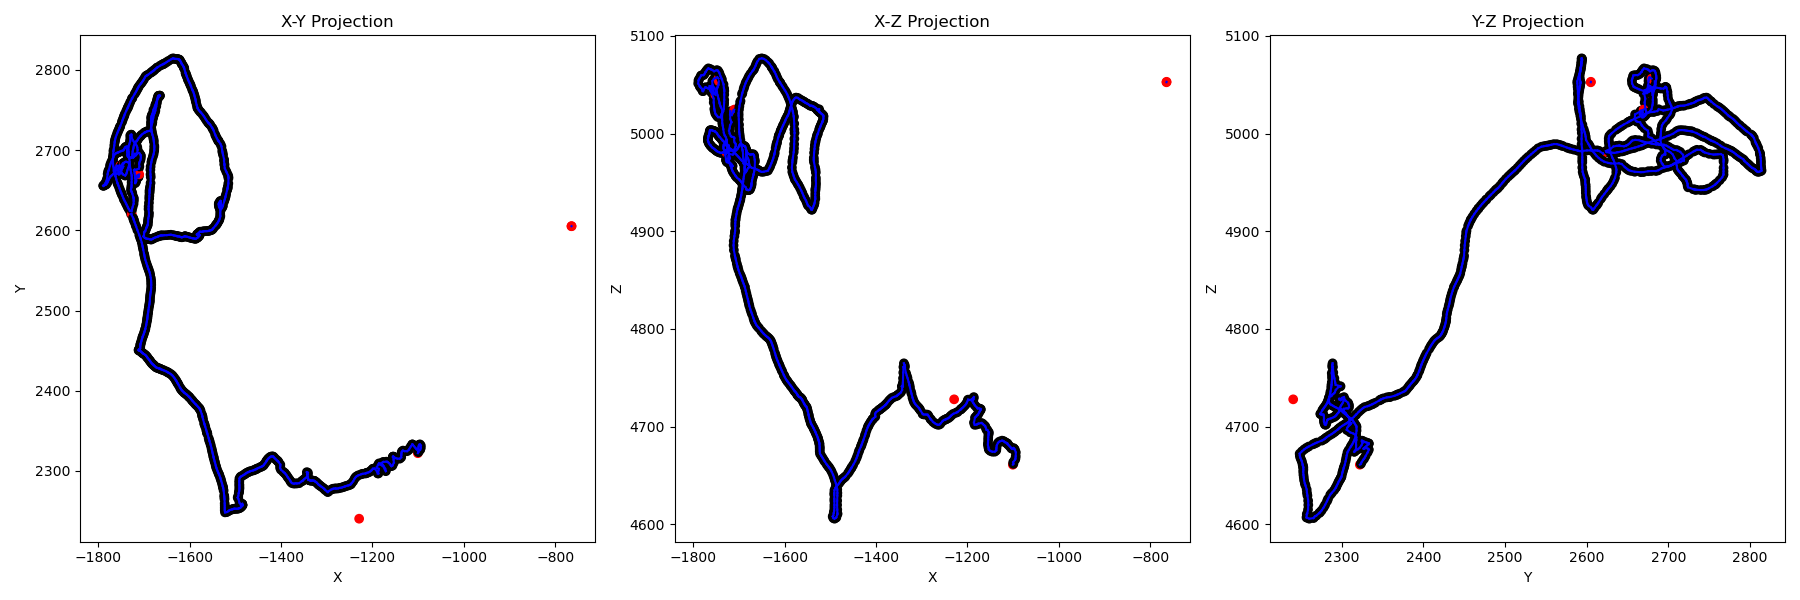

In [2]:
%matplotlib widget

data = hits[hits.event_id ==event_list[1]]
data = hits[hits.event_id ==395909]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Meadian_dist = GetMedianNodeDistances(data) # Median distance between nodes
init_dist_thresh = Meadian_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Meadian_dist*7, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_8061/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': 86, 'end': 276, 'nodes': [86, 80, 66, 55, 52, 42, 37, 41, 50, 44, 47, 56, 71, 72, 77, 82, 85, 95, 102, 108, 123, 129, 132, 140, 145, 153, 158, 159, 163, 164, 165, 161, 157, 149, 133, 130, 125, 118, 110, 104, 94, 76, 73, 53, 40, 30, 21, 19, 17, 15, 13, 10, 7, 6, 2, 1, 0, 3, 4, 5, 8, 9, 11, 12, 14, 16, 18, 20, 22, 29, 36, 49, 54, 64, 70, 79, 92, 99, 106, 113, 119, 121, 124, 127, 137, 136, 135, 134, 138, 139, 143, 146, 155, 167, 177, 193, 200, 202, 205, 206, 212, 222, 225, 231, 207, 197, 185, 182, 184, 180, 172, 175, 174, 170, 162, 151, 148, 152, 154, 156, 166, 168, 171, 176, 181, 191, 196, 194, 190, 188, 186, 183, 178, 187, 192, 201, 210, 213, 216, 219, 218, 214, 204, 199, 189, 169, 150, 142, 131, 126, 120, 114, 100, 96, 90, 87, 81, 69, 63, 58, 51, 46, 45, 35, 33, 28, 25, 23, 24, 26, 27, 31, 32, 34, 38, 39, 43, 48, 57, 61, 67, 78, 83, 84, 98, 103, 109, 116, 117, 122, 128, 141, 144, 147, 160, 173, 198, 203, 230, 244, 254, 262, 264, 274, 295, 302, 308, 316, 328, 343, 352

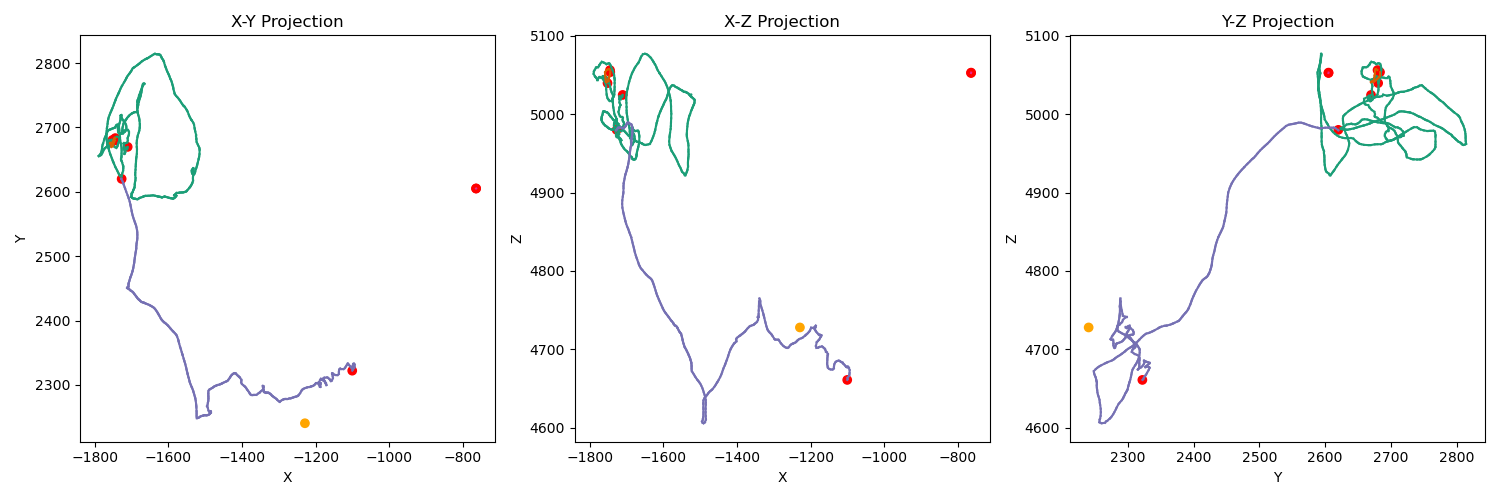

In [3]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [4]:
print(GetMedianNodeDist(Tracks, data))

dist_threshold = 4*GetMedianNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.261
Dist Thresh 13.044


In [5]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [6]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
True
Total Tracks: 5
{'id': 6, 'start': 1019, 'end': 1020, 'nodes': [1019, 1020], 'length': 0.588, 'energy': 0.03320719953626394, 'label': 'track', 'c': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)}
{'id': 7, 'start': 930, 'end': 930, 'nodes': [930], 'length': 0, 'energy': 0.019542399793863297, 'label': 'gamma', 'c': 'y'}
{'id': 8, 'start': 91, 'end': 115, 'nodes': [91, 97, 105, 107, 111, 115], 'length': 14.753, 'energy': 0.010688799840863794, 'label': 'track', 'c': 'black'}
{'id': 10, 'start': 189, 'end': 112, 'nodes': [189, 199, 204, 214, 218, 219, 216, 213, 210, 201, 192, 187, 178, 183, 186, 188, 190, 194, 196, 191, 181, 176, 171, 168, 166, 156, 154, 152, 148, 151, 162, 170, 174, 175, 172, 180, 184, 182, 185, 197, 207, 231, 225, 222, 212, 206, 205, 202, 200, 193, 177, 167, 155, 146, 143, 139, 138, 134, 135, 136, 137, 127, 124, 121, 119, 113, 106, 99, 92, 79, 70, 64, 54, 49, 36, 29, 22, 20, 18, 16, 14, 12, 11, 9, 8, 5, 4, 3, 0, 1, 2, 6, 7, 1

{'id': 0, 'start': 276, 'end': 1008, 'length': 2872.705, 'energy': 1.9219752004137263, 'label': 'Primary', 'c': 'Teal', 'nodes': [276, 265, 266, 269, 260, 251, 234, 238, 235, 236, 246, 248, 249, 237, 233, 228, 223, 229, 243, 253, 268, 278, 275, 280, 289, 299, 297, 296, 281, 273, 261, 227, 220, 215, 209, 211, 224, 239, 245, 255, 259, 257, 252, 242, 232, 240, 250, 256, 263, 271, 288, 292, 304, 323, 334, 345, 354, 366, 386, 413, 428, 437, 439, 443, 449, 455, 463, 466, 469, 473, 475, 476, 477, 480, 484, 487, 488, 493, 497, 498, 496, 492, 490, 485, 479, 472, 468, 452, 442, 435, 432, 421, 419, 423, 427, 433, 434, 436, 444, 450, 454, 456, 462, 464, 461, 460, 453, 447, 438, 429, 412, 408, 409, 417, 411, 404, 401, 397, 395, 394, 391, 389, 387, 382, 379, 388, 384, 376, 374, 373, 370, 365, 356, 351, 348, 342, 337, 332, 329, 326, 325, 321, 320, 319, 322, 331, 338, 344, 358, 363, 381, 392, 410, 431, 446, 459, 470, 482, 489, 491, 501, 502, 505, 510, 514, 519, 521, 526, 529, 533, 536, 537, 543, 546, 

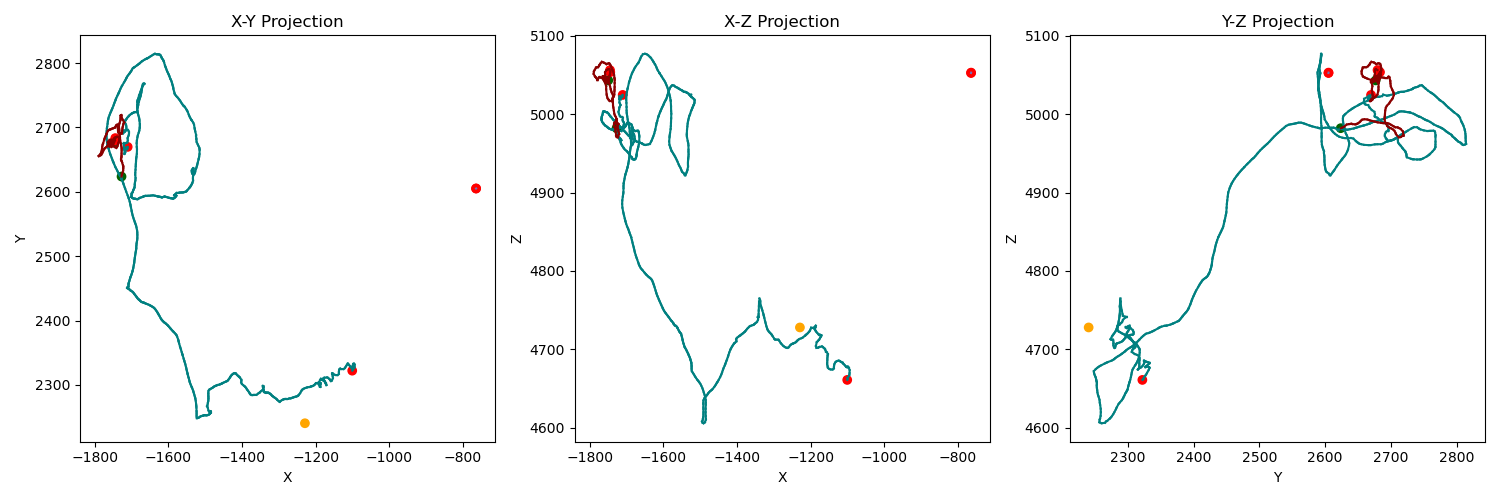

In [7]:
# def RebuildTracks(connected_nodes_, connection_count_, data):

#     RebuiltTrack_ = []
#     Track_arrays = []
#     Accounted_nodes = []
#     track_nodes = []

#     data_nodes = data.index.values.tolist()
#     remaining_nodes = data_nodes
#     trk_ids = 0
#     i = 0
    
#     # Loop over and build tracks
#     while remaining_nodes:
#         RebuildTracks_, remaining_nodes, trk_ids = MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, i, trk_ids, RebuiltTrack_)
#         i = i + 1

#     # Quality control
#     track_nodes = []
#     e_sum = 0
#     for t in RebuiltTrack_:
#         e_sum = e_sum+t["energy"]
#         track_nodes = track_nodes + t["nodes"]


#     ratio = e_sum / data.energy.sum()

#     if (ratio < 0.999 or ratio > 1.0001):
#         print("Ratio is off:", ratio)
#         return RebuiltTrack_, False

#     are_equal = set(track_nodes) == set(data_nodes)

#     if (not are_equal):
#         print("Missing Nodes:", set(data_nodes) - set(track_nodes))
#         return RebuiltTrack_, False

#     return RebuiltTrack_, True


# def MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, iteration, trk_ids, RebuiltTrack_):

#     Track_arrays = []

#     prim_track_id = -1
#     prim_track_arr = []
#     prim_energy = 0
#     prim_len = 0

#     # Get all nodes with single connections
#     end_points = np.where(connection_count_ == 1)[0]
#     end_points = [x for x in end_points if x in remaining_nodes]

#     if (iteration == 0):
#         primary_label = "Primary"
#         delta_label = "Delta"
#         color = "Teal"
#     else:
#         primary_label = "Brem"
#         delta_label = "BremDelta"
#         color = next(color_cycle)

#     for index, end_point in enumerate(end_points):
#         trkpath = GetLongestPath(connected_nodes_, end_point)
#         Track_arrays.append(trkpath)

#         trk_length = GetTrackLength(trkpath, data)
#         print(trk_length, prim_len)

#         if (trk_length > prim_len):
#             prim_len = trk_length
#             prim_track_id = index
#             prim_track_arr = trkpath
#             prim_energy = GetTrackEnergy(trkpath, data, False)
    
#     print("trk_length", prim_len, primary_label, iteration)

#     # Create the primary track
#     RebuiltTrack_.append({"id":trk_ids, "start":prim_track_arr[0], "end":prim_track_arr[-1], "length":prim_len, "energy":prim_energy, "label":primary_label, "c":color, "nodes":prim_track_arr})
#     trk_ids = trk_ids + 1

#     # Get all nodes with three connections in the primary track
#     multi_connections = np.where(connection_count_ == 3)[0]
#     prim_track_multi_connections = [x for x in multi_connections if x in prim_track_arr]

#     for node in prim_track_multi_connections:
#         delta_node = [x for x in connected_nodes_[node] if x not in prim_track_arr]

#         if (len(delta_node) > 1):
#             print("Error the delta node has more than one node after cut")

#         delta_paths = GetDeltaPath(connected_nodes_, node , delta_node[0], 0)
    
#         for t in range(len(delta_paths)):
#             trkpath = delta_paths[t]
#             trk_energy = GetTrackEnergy(trkpath, data, True)
#             trk_length = GetTrackLength(trkpath, data)
#             RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":trk_length, "energy":trk_energy, "label":f"{delta_label}{t}", "c":"DarkRed", "nodes":trkpath})
#             trk_ids = trk_ids + 1


#     # This is for single nodes
#     single_points = np.where(connection_count_ == 0)[0]
#     single_points = [x for x in single_points if x in remaining_nodes] # Removes ones that have already been added

#     for index, single_point in enumerate(single_points):
#         trkpath = [single_point]
#         energy = GetTrackEnergy(trkpath, data, False)
#         RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":0, "energy":energy, "label":"Brem", "c":"Orange", "nodes":trkpath})
#         trk_ids = trk_ids + 1


#     track_nodes = []
#     for t in RebuiltTrack_:
#         track_nodes = track_nodes + t["nodes"]
#     remaining_nodes = list(set(data_nodes) - set(track_nodes))

#     return RebuiltTrack_, remaining_nodes, trk_ids



RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [8]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
0,395909,-1710.204590,2669.738770,5024.486328,0.023659,276,1,0,0.000000,0.000000
1,395909,-1712.005493,2666.191650,5022.440430,0.002852,265,1,0,4.473366,104.396892
2,395909,-1711.693848,2666.782471,5023.446777,0.042706,266,1,0,5.681227,150.783993
3,395909,-1711.400269,2668.291748,5022.277832,0.004414,269,1,0,7.612688,94.749381
4,395909,-1713.725952,2668.540771,5021.351562,0.005977,260,1,0,10.128397,80.812301
...,...,...,...,...,...,...,...,...,...,...
1016,395909,-1747.171631,2677.280273,5057.439941,0.000099,101,0,2,67.474039,10.666116
1017,395909,-1744.644775,2679.621094,5056.203613,0.005506,112,0,2,71.133676,38.633873
1018,395909,-1229.025757,2240.479736,4727.823730,0.019542,930,0,3,0.000000,0.000000
1019,395909,-764.492310,2605.027832,5052.460449,0.001463,1019,0,4,0.000000,0.000000


{0: [1, 3], 1: [0, 2], 2: [1, 6], 3: [4, 0], 4: [3, 5], 5: [4, 8], 6: [7, 2], 7: [6, 10], 8: [9, 5], 9: [8, 11], 10: [7, 13], 11: [12, 9], 12: [11, 14], 14: [12, 16], 13: [15, 10], 15: [13, 17], 16: [18, 14], 18: [16, 20], 17: [19, 15], 19: [17, 21], 20: [18, 22], 21: [19, 30], 22: [29, 20], 29: [22, 36], 23: [25, 24], 25: [23, 28], 24: [26, 23], 26: [24, 27], 28: [25, 33], 27: [26, 31], 30: [21, 40], 31: [32, 27], 32: [31, 34], 33: [35, 28], 35: [33, 45], 34: [38, 32], 38: [34, 39], 36: [49, 29], 49: [36, 54], 37: [42, 41], 42: [37, 52], 39: [38, 43], 43: [39, 48], 40: [53, 30], 53: [40, 73], 41: [50, 37], 50: [41, 44], 44: [47, 50], 47: [44, 56], 45: [46, 35], 46: [45, 51], 48: [43, 57], 54: [49, 64], 51: [46, 58], 52: [42, 55], 55: [66, 52], 66: [55, 80], 56: [47, 71], 57: [61, 48], 61: [57, 67], 58: [63, 51], 63: [58, 69], 59: [74, 60], 74: [59, 89], 60: [62, 59], 62: [60, 65], 67: [61, 78], 64: [70, 54], 70: [64, 79], 65: [68, 62], 68: [65, 75], 69: [63, 81], 79: [70, 92], 71: [72

Text(0, 0.5, 'Scatter Angle [deg]')

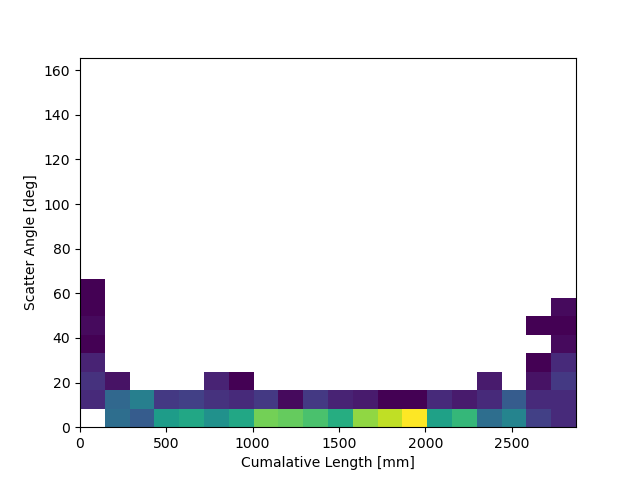

In [9]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

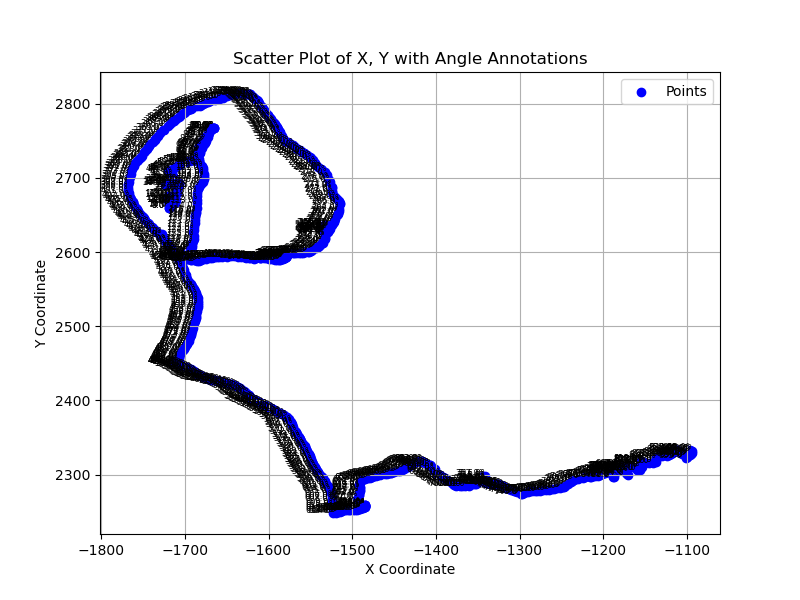

In [10]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [11]:
# Calculate Track Tortuosity

df_angles = CalcTortuosity(df_angles)

In [12]:
display(df_angles)

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity
0,395909,-1710.204590,2669.738770,5024.486328,0.023659,276,1,0,0.000000,0.000000,1.947051
1,395909,-1712.005493,2666.191650,5022.440430,0.002852,265,1,0,4.473366,104.396892,2.194017
2,395909,-1711.693848,2666.782471,5023.446777,0.042706,266,1,0,5.681227,150.783993,2.365325
3,395909,-1711.400269,2668.291748,5022.277832,0.004414,269,1,0,7.612688,94.749381,2.775748
4,395909,-1713.725952,2668.540771,5021.351562,0.005977,260,1,0,10.128397,80.812301,2.519817
...,...,...,...,...,...,...,...,...,...,...,...
1016,395909,-1747.171631,2677.280273,5057.439941,0.000099,101,0,2,67.474039,10.666116,1.370625
1017,395909,-1744.644775,2679.621094,5056.203613,0.005506,112,0,2,71.133676,38.633873,1.280537
1018,395909,-1229.025757,2240.479736,4727.823730,0.019542,930,0,3,0.000000,0.000000,0.000000
1019,395909,-764.492310,2605.027832,5052.460449,0.001463,1019,0,4,0.000000,0.000000,1.000000


856


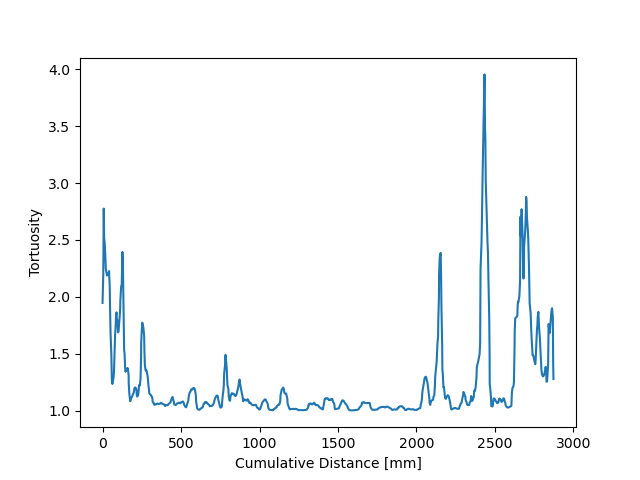

In [13]:
plt.figure()

plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Tortuosity")

# plt.figure()

# plt.hist(df_angles[df_angles.trkID == 0].cumulative_distance, weights = df_angles[df_angles.trkID == 0].energy, bins = 20)
# plt.xlabel("Cumulative Distance [mm]")
# plt.ylabel("Energy [MeV]")


print(len(df_angles[df_angles.trkID == 0]))

Window: 9
Window: 5
Window: 5
Window: 5
Window: 5


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
0,395909,-1710.204590,2669.738770,5024.486328,0.023659,276,1,0,0.000000,0.000000,1.947051,1.257248
1,395909,-1712.005493,2666.191650,5022.440430,0.002852,265,1,0,4.473366,104.396892,2.194017,1.560555
2,395909,-1711.693848,2666.782471,5023.446777,0.042706,266,1,0,5.681227,150.783993,2.365325,1.876649
3,395909,-1711.400269,2668.291748,5022.277832,0.004414,269,1,0,7.612688,94.749381,2.775748,2.401429
4,395909,-1713.725952,2668.540771,5021.351562,0.005977,260,1,0,10.128397,80.812301,2.519817,2.428293
...,...,...,...,...,...,...,...,...,...,...,...,...
1016,395909,-1747.171631,2677.280273,5057.439941,0.000099,101,0,2,67.474039,10.666116,1.370625,0.878681
1017,395909,-1744.644775,2679.621094,5056.203613,0.005506,112,0,2,71.133676,38.633873,1.280537,0.678168
1018,395909,-1229.025757,2240.479736,4727.823730,0.019542,930,0,3,0.000000,0.000000,0.000000,0.000000
1019,395909,-764.492310,2605.027832,5052.460449,0.001463,1019,0,4,0.000000,0.000000,1.000000,0.000403


Text(0, 0.5, 'Squiglicity')

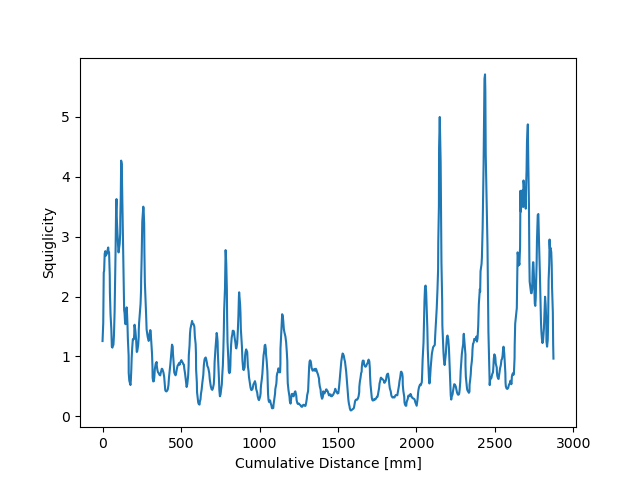

In [14]:

# Step 3: Compute perpendicular distances
def point_to_line_distance(P, A, D):
    return np.linalg.norm(np.cross(P - A, D)) / np.linalg.norm(D)

def CalcSquiglicity(df_angles):

    # df_angles['distance_diff'] = df_angles.groupby(['event_id', 'trkID'])['cumulative_distance'].diff().fillna(0)

    df_angles["Squiglicity"] = 1.0

    Squiglicity = []

    window = 10

    for trkID in df_angles.trkID.unique():

        # Get the track
        trk_df = df_angles[df_angles.trkID == trkID]

        # Try to dynamically calculate the window size by splitting into 100 pieces
        window = int(len(trk_df)/100 + 1)
        if window < 5:
            window = 5
        print("Window:",window)

        # Loop over the nodes in the track
        for index in range(len(trk_df)):

            start = max(0, index - window)  # Prevent going below index 0
            end = min(len(trk_df), index + window + 1)  # Prevent exceeding last index
            
            temp_df = trk_df.iloc[start:end]

            point1 = temp_df.iloc[0]
            point2 = temp_df.iloc[-1]
            segment_length = calculate_distance(point1, point2)

            # Avoids division by zero
            if (segment_length == 0):
                segment_length = 1


            points = temp_df[['x', 'y', 'z']].values # Get the points
            
            # Step 1: Compute centroid (a point on the best-fit line)
            A = np.mean(points, axis=0)
           
            # Step 2: Compute best-fit direction vector using SVD
            U, S, Vt = np.linalg.svd(points - A)
            D = Vt[0]  # First right-singular vector (best-fit direction)

            temp_df['distance_to_line'] = [point_to_line_distance(P, A, D) for P in points]

            # Step 4: Sum of distances
            cum_distance = temp_df['distance_to_line'].sum()

            Squiglicity.append(cum_distance/segment_length)

    df_angles["Squiglicity"] = Squiglicity

    return df_angles


df_angles = CalcSquiglicity(df_angles)
display(df_angles)


plt.figure()
plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Squiglicity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Squiglicity")


In [15]:
Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 180, 200, 1) # scale these params inversely with the pressure

display(Track_df)

print(Track_df.energy.sum())



distance_threshold, radius_threshold, T_threshold, pressure:  500 180 200 1
end_tresh: 2672.704891065819 2872.704891065819 200 1 63
     event_id            x            y            z    energy    id  primary  \
793    395909 -1175.044434  2305.701416  4718.559082  0.004687   965        1   
794    395909 -1172.129150  2302.731934  4718.114746  0.000322   968        1   
795    395909 -1172.648926  2302.335205  4715.834473  0.000223   967        1   
796    395909 -1171.045410  2300.416992  4717.065430  0.005778   969        1   
797    395909 -1170.697632  2299.738525  4717.691895  0.002728   970        1   
798    395909 -1174.752808  2304.481201  4714.063477  0.000868   966        1   
799    395909 -1176.942749  2306.039307  4712.130371  0.000546   963        1   
800    395909 -1179.126709  2306.862549  4711.259277  0.002554   960        1   
801    395909 -1181.287720  2307.782959  4710.014648  0.001587   957        1   
802    395909 -1183.463013  2308.867676  4709.029785  0.00

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,395909,0,1,276,1008,2872.705,1.921975,0.424626,0.541310,0.860386,0.384375,1.722371,1.762513,341.869063,350.876120,2.114046,2.480471,420.622572,495.595380,Primary
0,395909,1,0,189,91,480.563,0.416491,0.416491,0.416491,0.000000,0.416491,1.389766,1.210550,266.135582,232.648373,0.988430,0.757172,181.892157,137.249204,Delta0
0,395909,2,0,91,112,71.134,0.071994,0.071994,0.071994,0.000000,0.071994,2.903651,2.903651,212.329533,212.329533,2.015566,2.015566,149.107924,149.107924,Delta1
0,395909,3,0,930,930,0.000,0.019542,0.019542,0.019542,0.019542,0.019542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,395909,4,0,1019,1020,0.588,0.033207,0.033207,0.033207,0.033207,0.033207,1.000000,1.000000,0.587836,0.587836,0.000403,0.000403,0.000237,0.000237,Brem


2.463210400484968


In [16]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


Adding Delta0 energy to blob1 as dist was 64.8216781616211
Adding Delta1 energy to blob1 as dist was 43.89567565917969


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,395909,0,1,276,1008,2872.705,1.921975,0.913111,0.541310,1.348872,0.384375,6.015787,1.762513,820.334178,350.876120,5.118043,2.480471,751.622653,495.595380,Primary
0,395909,1,0,189,91,480.563,0.416491,0.416491,0.416491,0.000000,0.416491,1.389766,1.210550,266.135582,232.648373,0.988430,0.757172,181.892157,137.249204,Delta0
0,395909,2,0,91,112,71.134,0.071994,0.071994,0.071994,0.000000,0.071994,2.903651,2.903651,212.329533,212.329533,2.015566,2.015566,149.107924,149.107924,Delta1
0,395909,3,0,930,930,0.000,0.019542,0.019542,0.019542,0.019542,0.019542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Brem
0,395909,4,0,1019,1020,0.588,0.033207,0.033207,0.033207,0.033207,0.033207,1.000000,1.000000,0.587836,0.587836,0.000403,0.000403,0.000237,0.000237,Brem
